https://chat.openai.com/share/98bd9fe3-f8ae-4ff4-859a-dd4a7855c429

In [3]:
from dendropy.simulate import treesim
import dendropy
from Bio import Phylo
from io import StringIO
import Bio.Phylo.BaseTree
import numpy as np
import random
import matplotlib.pyplot as plt
import torch 
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle

# Generate birth death trees

In [4]:
#birth_death_tree returns a tree generated under a continuous-time birth-death process, with branch lengths in arbitrary time units.
t_cont= treesim.birth_death_tree(birth_rate=2.0, death_rate=1.0,max_time=2)
t_cont.print_plot()

                                                                  /-------- T2 
                                                          /-------+            
                                                  /-------+       \-------- T17
                                                  |       |                    
                                 /----------------+       \---------------- T13
                                 |                |                            
                                 |                \------------------------ T3 
/--------------------------------+                                             
|                                |       /--------------------------------- T9 
|                                |       |                                     
|                                \-------+                /---------------- T20
|                                        |        /-------+                    
|                                       

# Convert to Newick string

In [5]:
newick_str = t_cont.as_string(schema="newick")
file = StringIO(newick_str)
bio_phylo_tree = Phylo.read(file, "newick")

# Get node living data

In [6]:
#FIX NAMING
def get_living_times(tree, node, name_num=0, Dist = {}):
    if node == tree.root:
        node.name = "C"+str(name_num)
        Dist[node.name] = [0,0]
    if len(node.clades)!=0:
        for child in node.clades:
            if (child.name==None):
                name_num += 1
                child.name = "C"+ str(name_num)
            dist = Dist[node.name][1]
            Dist[child.name] = [dist,dist + child.branch_length]
            get_living_times(tree, child, name_num+1)
    return Dist

In [7]:
print(get_living_times(bio_phylo_tree, bio_phylo_tree.root))

{'C0': [0, 0], 'C1': [0, 0.7820556206902426], 'C3': [0.7820556206902426, 1.670315706026682], 'C5': [1.670315706026682, 1.7618100683816678], 'C7': [1.24366097796669, 1.4094862188211241], 'T2': [1.9015210951304968, 1.9956857725615997], 'T17': [1.9015210951304968, 1.9956857725615997], 'T13': [1.7618100683816678, 1.9956857725615997], 'T3': [1.670315706026682, 1.9956857725615997], 'C4': [1.1399570838330642, 1.24366097796669], 'T9': [0.9386293334290249, 1.9956857725615995], 'C6': [1.24366097796669, 1.7870045328983242], 'C8': [1.6144035041533145, 1.6373466163584511], 'T20': [1.6373466163584511, 1.9956857725615995], 'C10': [1.6373466163584511, 1.9582478770708742], 'T4': [1.9582478770708742, 1.9956857725615995], 'T12': [1.9582478770708742, 1.9956857725615995], 'T16': [1.6144035041533145, 1.9956857725615995], 'C2': [0, 1.1399570838330642], 'T19': [1.7870045328983242, 1.9956857725615997], 'T5': [1.7870045328983242, 1.9956857725615997], 'T1': [1.4094862188211241, 1.9956857725616], 'C9': [1.4094862

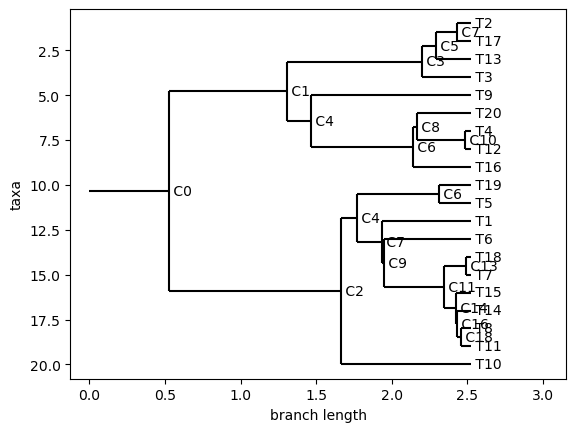

In [8]:
Phylo.draw(bio_phylo_tree)


# Collapse Tree - Trial run

In [9]:
#just using arbitrary bias and weights rn for testing
bias = np.array([[1],[1]])
weights = np.array([[0.5,0.1, 0.2, 0.2],[0.3,0.2, 0.1, 0.6]])
living_dict = get_living_times(bio_phylo_tree, bio_phylo_tree.root)

#turn dictionary of birth & death of nodes in list format into np vector format
def vectorize_dict(D):
    for node, [birth, death] in D.items():
        D[node] = np.array([birth, death]).reshape(2, 1)
    return D

living_dict = vectorize_dict(living_dict)

In [10]:
# collapse all living times to 1 vector
def collapse_tree(living_dict, tree, node):
    if len(node.clades)==0:
        #leaf node
        return living_dict[node.name]
    else:
        result = np.concatenate((collapse_tree(living_dict, tree, node.clades[0]), collapse_tree(living_dict, tree, node.clades[1])), axis=0)
        return np.add(np.matmul(weights,result), bias)

In [11]:
print(collapse_tree(living_dict, bio_phylo_tree, bio_phylo_tree.root))

[[5.99219018]
 [7.14387336]]


# Generate tree dataset

In [19]:
simulated_trees = []
matching_parameters = []

#WRITE THESE TO FILE PICKLE
for i in range(0,1000):
    #rate_birth = random.random()
    rate_death = random.random()+1
    R = random.uniform(1,2)
    rate_birth = rate_death * R

    #This somehow only works if birth_rate=1.0??? CHECK THIS
    #print(str(rate_birth)+" " + str(rate_death) + " ")
    t_cont= treesim.birth_death_tree(birth_rate=rate_birth, death_rate=rate_death, max_time=4)
    simulated_trees.append(t_cont)
    matching_parameters.append([rate_birth,rate_death])
    if (i%50==0):
        print(i)

file_tree = open('tree.pickle', 'wb')
file_param = open('param.pickle','wb')
pickle.dump(simulated_trees,file_tree)
pickle.dump(matching_parameters,file_param)
file_tree.close()
file_param.close()

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [12]:
bio_phylo_simulated_trees = []

with open('tree.pickle','rb') as f:
    get_pickled_trees = pickle.load(f)

with open('param.pickle','rb') as f:
    get_pickled_param = pickle.load(f)

#convert newick trees into bio phylo tree objects
for tree in get_pickled_trees:
    newick_str = tree.as_string(schema="newick")
    file = StringIO(newick_str)
    bio_phylo_tree = Phylo.read(file, "newick")
    bio_phylo_simulated_trees.append(bio_phylo_tree)
    

In [13]:
x,y = bio_phylo_simulated_trees, get_pickled_param

y=np.array(y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=5)
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))
y_train.requires_grad_(True)
y_test.requires_grad_(True)

tensor([[2.1398, 1.8580],
        [2.5976, 1.7687],
        [2.4791, 1.4463],
        [3.1890, 1.6276],
        [1.5927, 1.5088],
        [2.4820, 1.3908],
        [1.4752, 1.0059],
        [3.0634, 1.6159],
        [2.5343, 1.3521],
        [1.8768, 1.4296],
        [2.0851, 1.6186],
        [3.1505, 1.9288],
        [2.1466, 1.9896],
        [1.7302, 1.4661],
        [1.6685, 1.4186],
        [2.1798, 1.6847],
        [1.5249, 1.1760],
        [2.1057, 1.5650],
        [1.9877, 1.3906],
        [2.2601, 1.1347],
        [2.4058, 1.4805],
        [1.9562, 1.4435],
        [1.9767, 1.0788],
        [2.8597, 1.8478],
        [2.2104, 1.1724],
        [2.2742, 1.4091],
        [1.9788, 1.3961],
        [3.2676, 1.6468],
        [1.8738, 1.5541],
        [2.0931, 1.3882],
        [1.6045, 1.3206],
        [1.8623, 1.4007],
        [2.2992, 1.7066],
        [1.5026, 1.2664],
        [2.6371, 1.8119],
        [2.1169, 1.0873],
        [1.1580, 1.0481],
        [2.3724, 1.6565],
        [1.2

# Neural network

In [103]:
PADDED_DIM=4

class treeProcessor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(treeProcessor, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, living_dict):
        survival = living_dict[x.name]
        temp = torch.tensor(survival, dtype=torch.float32)
        temp = temp.reshape(2, 1)
        
        if len(x.clades) == 0:
            # Terminal node
            #PAD WITH ZEROES, CHANGE OUTPUT_DIM = k, INPUT_DIM = k
            return (temp.detach().clone()) #shape k 

        L_collapsed = self.forward(x.clades[0], living_dict)
        L_collapsed = L_collapsed.reshape(2, 1)
        
        R_collapsed = self.forward(x.clades[1], living_dict)
        R_collapsed = R_collapsed.reshape(2, 1)

        #import pdb; pdb.set_trace()
        result = torch.cat((temp, L_collapsed, R_collapsed), dim=0).squeeze(1)
        #result = result.reshape(6, 1)

        return (self.sigmoid(self.linear(result)))  #shape k

In [104]:
hi = treeProcessor(6,10,2)


In [105]:
d = vectorize_dict(get_living_times(bio_phylo_tree, bio_phylo_tree.root))
hi(bio_phylo_tree.root, d)

tensor([0.4328, 0.5164], grad_fn=<SigmoidBackward0>)

In [183]:
class myModel(nn.Module):
    def __init__(self, input_dim: int, 
               hidden_dim: int, output_dim: int):
        super(myModel,self).__init__()
        self.recursive_tree_processor = treeProcessor(6, 10, 2)
        self.myModel=nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self,tree):
        dict = vectorize_dict(get_living_times(tree, tree.root))
        x=self.myModel((self.recursive_tree_processor(tree.root,dict)).reshape(1,2))
        #x.requires_grad_(True)
        return x

In [184]:
input_dim = 2
hidden_dim = 10
batch_size = 4
num_workers = 4
output_dim = 2

model = myModel(input_dim, hidden_dim, output_dim)
print(model)

myModel(
  (recursive_tree_processor): treeProcessor(
    (linear): Linear(in_features=6, out_features=2, bias=True)
    (sigmoid): Sigmoid()
  )
  (myModel): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=10, out_features=2, bias=True)
  )
)


In [185]:
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) #TOO HIGH LEARNING RATE

In [186]:
print(y_train)

tensor([[1.6366, 1.1588],
        [1.9863, 1.2069],
        [2.2120, 1.8599],
        ...,
        [2.2020, 1.8840],
        [2.9700, 1.7252],
        [2.6091, 1.9556]], requires_grad=True)


In [187]:
e = []
l = []

In [188]:
print(model(bio_phylo_tree))

tensor([[ 0.4647, -0.8000]], grad_fn=<AddmmBackward0>)


In [195]:
for epoch in range(100,200):
    total_loss = 0  # Initialize total loss for the epoch
    for param in model.parameters():
        param.requires_grad_(True)
    
    for _ in range(len(x_train)):
        i = random.randint(0,len(x_train)-1)
        predict_y = model(x_train[i]).squeeze(0)
        #print(predict_y)
        loss = loss_func(predict_y, y_train[i])
        total_loss = total_loss + loss.item()

        # Backward and optimization steps
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        predict_y.detach()

    # Print average loss for the epoch
    avg_loss = total_loss / (len(x_train))
    print(f'Epoch {epoch}, Average Loss: {avg_loss}')

    # Append to lists for plotting or analysis
    e.append(epoch)
    l.append(avg_loss)

Epoch 100, Average Loss: 0.13248726559338966
Epoch 101, Average Loss: 0.14652131782026281
Epoch 102, Average Loss: 0.14528306001117938
Epoch 103, Average Loss: 0.15879855287250882
Epoch 104, Average Loss: 0.14385861186979604
Epoch 105, Average Loss: 0.15285039900405917
Epoch 106, Average Loss: 0.15355272290597446
Epoch 107, Average Loss: 0.15420547282208563
Epoch 108, Average Loss: 0.12206465655958641
Epoch 109, Average Loss: 0.14189377750570664
Epoch 110, Average Loss: 0.15241766977167354
Epoch 111, Average Loss: 0.1392946314557504
Epoch 112, Average Loss: 0.14170953047725915
Epoch 113, Average Loss: 0.14596249335905911
Epoch 114, Average Loss: 0.14227501094973743
Epoch 115, Average Loss: 0.15374191191374087
Epoch 116, Average Loss: 0.15549627372051533
Epoch 117, Average Loss: 0.1399249122860327
Epoch 118, Average Loss: 0.14872939748413264
Epoch 119, Average Loss: 0.14143151874243934
Epoch 120, Average Loss: 0.14108384180094685
Epoch 121, Average Loss: 0.14559718219019516
Epoch 122, A

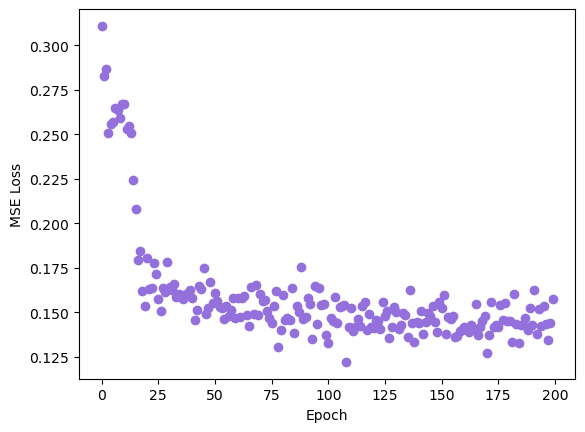

<Figure size 640x480 with 0 Axes>

In [196]:
plt.scatter(np.array(e), np.array(l), color='mediumpurple')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()
plt.savefig("epoch_BD1.svg")

In [197]:
PATH = './tree_model.pth'
torch.save(model.state_dict(), PATH)

In [198]:
model = myModel(input_dim, hidden_dim, output_dim)
model.load_state_dict(torch.load(PATH))

with torch.no_grad():
    total_loss = 0.0
    #temp = x_test
    #rand_vector = random.sample(range(0, len(temp) -1),random.randint((len(temp)-1)//2, len(temp)-1))
    #selected = [temp[i] for i in rand_vector]
    predictions = []
    labels = []
    
    #temp1 = y_test
    #selected_test = [temp1[i] for i in rand_vector]

    for i in range(0,len(x_test)):
        predict_y = model(x_test[i]).squeeze(0)
        predictions.append(predict_y.detach().numpy())
        labels.append(y_test[i].detach().numpy())
        loss = loss_func(predict_y, y_test[i])
        #print(loss.item())
        total_loss += loss.item()
    print(f'MSE Loss: {total_loss/len(x_test)}')


MSE Loss: 0.14169376525678673


In [199]:
#plot birth rate
prediction_birth = []
prediction_death = []
actual_birth = []
actual_death = []
for i in predictions:
    prediction_birth.append(i[0])
    prediction_death.append(i[1])
for i in labels:
    actual_birth.append(i[0])
    actual_death.append(i[1])


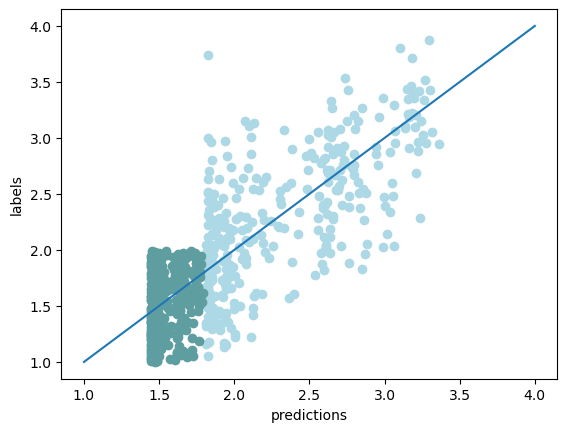

In [200]:
plt.scatter(prediction_birth, actual_birth, color = 'lightblue')
plt.scatter(prediction_death, actual_death, color = 'cadetblue')
plt.plot([1,4],[1,4])
plt.xlabel("predictions")
plt.ylabel("labels")
plt.savefig("predictions_BD1.svg")

In [ ]:
#first 100 epochs w 0.1 lr